# The Boston Housing Dataset

It has two prototasks: 
- `nox`, in which the nitrous oxide level is to be predicted 
- `price`, in which the median value of a home is to be predicted

## Atributes:
There are 14 attributes in each case of the dataset. They are:

| Attribute | Explanation |
| :--------- | :----------- |
| CRIM | per capita crime rate by town |
| ZN | proportion of residential land zoned for lots over 25,000 sq.ft. |
| INDUS | proportion of non-retail business acres per town. |
| CHAS | Charles River dummy variable (1 if tract bounds river; 0 otherwise) |
| NOX | nitric oxides concentration (parts per 10 million) |
| RM | average number of rooms per dwelling |
| AGE | proportion of owner-occupied units built prior to 1940 |
| DIS | weighted distances to five Boston employment centres |
| RAD | index of accessibility to radial highways |
| TAX | full-value property-tax rate per 10,000 dollars |
| PTRATIO | pupil-teacher ratio by town |
| B | 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town |
| LSTAT | % lower status of the population |
| MEDV | Median value of owner-occupied homes in 1000's dollars |

In [1]:
# Use seaborn for pairplot
!pip install seaborn

You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [3]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.1.0


### Get dataset
Import downloaded dataset using pandas

In [4]:
column_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
boston_raw = pd.read_csv('housing.csv', header=None, delimiter=r"\s+", names=column_names)

boston = boston_raw.copy()
boston.tail()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
501,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273.0,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273.0,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273.0,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273.0,21.0,393.45,6.48,22.0
505,0.04741,0.0,11.93,0,0.573,6.030,80.8,2.5050,1,273.0,21.0,396.90,7.88,11.9


Check if there are unknown values

In [5]:
# check unknown values
boston.isna().sum()

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64

### Split the data into train and test

Now split the dataset into a training set and a test set.

We will use the test set in the final evaluation of our model.

In [6]:
train_boston = boston.sample(frac=0.8, random_state=0)
test_boston = boston.drop(train_boston.index)

### Inspect the data

Have a quick look at the joint distribution of a few pairs of columns from the training set.

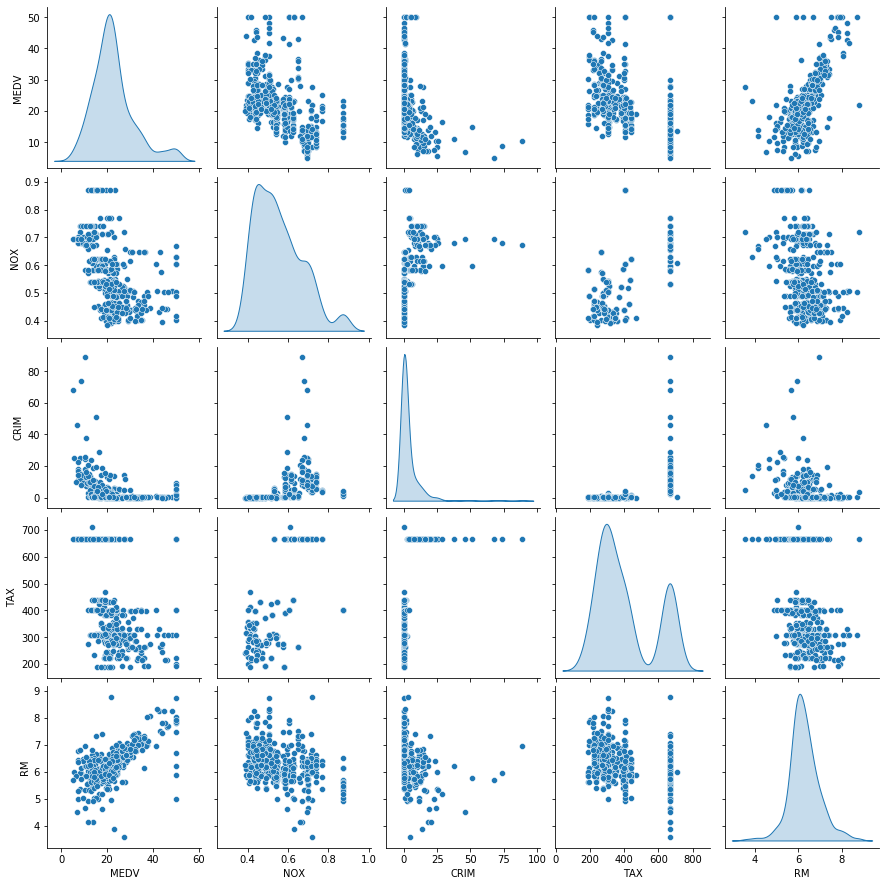

In [7]:
sns.pairplot(train_boston[['MEDV', 'NOX', 'CRIM', 'TAX', 'RM']], diag_kind='kde')

Also look at the overall statistics:

In [8]:
train_stats = train_boston.describe()
train_stats.pop("MEDV")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
CRIM,405.0,3.670339,8.977954,0.00632,0.08265,0.26838,3.47428,88.9762
ZN,405.0,11.067901,22.688396,0.00000,0.00000,0.00000,12.50000,95.0000
INDUS,405.0,11.097951,6.699157,0.74000,5.32000,9.69000,18.10000,27.7400
CHAS,405.0,0.069136,0.253999,0.00000,0.00000,0.00000,0.00000,1.0000
NOX,405.0,0.553098,0.115564,0.38500,0.44900,0.53800,0.62400,0.8710
RM,405.0,6.269768,0.690552,3.56100,5.87800,6.19300,6.61900,8.7800
AGE,405.0,68.241975,27.908527,2.90000,45.00000,76.50000,94.10000,100.0000
DIS,405.0,3.834098,2.162173,1.12960,2.07880,3.27210,5.21460,12.1265
RAD,405.0,9.474074,8.618564,1.00000,4.00000,5.00000,24.00000,24.0000
TAX,405.0,405.839506,164.057951,187.00000,284.00000,334.00000,666.00000,711.0000


### Split features from labels

Separate the target value, or "label", from the features. This label is the value that you will train the model to predict.

In [9]:
train_labels = train_boston.pop('MEDV')
test_labels = test_boston.pop('MEDV')

### Normalize the data

According TF regression tutorial it is a good idea to normalize data before regression.

Look again at the train_stats block above and note how different the ranges of each feature are.

It is good practice to normalize features that use different scales and ranges. Although the model might converge without feature normalization, it makes training more difficult, and it makes the resulting model dependent on the choice of units used in the input.

Note: Although we intentionally generate these statistics from only the training dataset, these statistics will also be used to normalize the test dataset. We need to do that to project the test dataset into the same distribution that the model has been trained on.

In [10]:
# The tf.keras.layers.Normalization is a clean and simple way to add feature normalization into your model.
# It is true but since version 2.6.0
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_boston)
normed_test_data = norm(test_boston)

This normalized data is what we will use to train the model.

## The model

### Build the model

Let's build our model. Here, we'll use a Sequential model with: 

- The normalization layer for a multiple-input model
- Two hidden, non-linear, Dense layers with the ReLU (relu) activation function.
- A linear Dense single-output layer.

In [72]:
def build_model():
  model = keras.Sequential([
    layers.Dense(13, input_shape=(13,), activation='relu'),
    layers.Dense(5, activation='relu'),
    layers.Dense(5, activation='relu'),
    # regression - no activation function in the last layer
    layers.Dense(1)
  ])

  model.compile(loss='mse',
                optimizer=tf.optimizers.Adam(learning_rate=0.01))
                # optimizer = tf.keras.optimizers.RMSprop(0.001))
  return model

In [73]:
model = build_model()

### Inspect the model

Use the .summary method to print a simple description of the model

In [74]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_28 (Dense)             (None, 13)                182       
_________________________________________________________________
dense_29 (Dense)             (None, 64)                896       
_________________________________________________________________
dense_30 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 65        
Total params: 5,303
Trainable params: 5,303
Non-trainable params: 0
_________________________________________________________________


Now try out the model. Take a batch of 10 examples from the training data and call model.predict on it.

In [75]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[0.081],
       [0.19 ],
       [0.364],
       [0.348],
       [0.122],
       [0.13 ],
       [0.118],
       [0.165],
       [0.281],
       [0.588]], dtype=float32)

### Train the model

Train the model for 1000 epochs, and record the training and validation accuracy in the history object.

In [76]:
%%time
EPOCHS = 100

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0)

CPU times: user 5.8 s, sys: 999 ms, total: 6.8 s
Wall time: 3.96 s


Visualize the model's training progress using the stats stored in the history object.

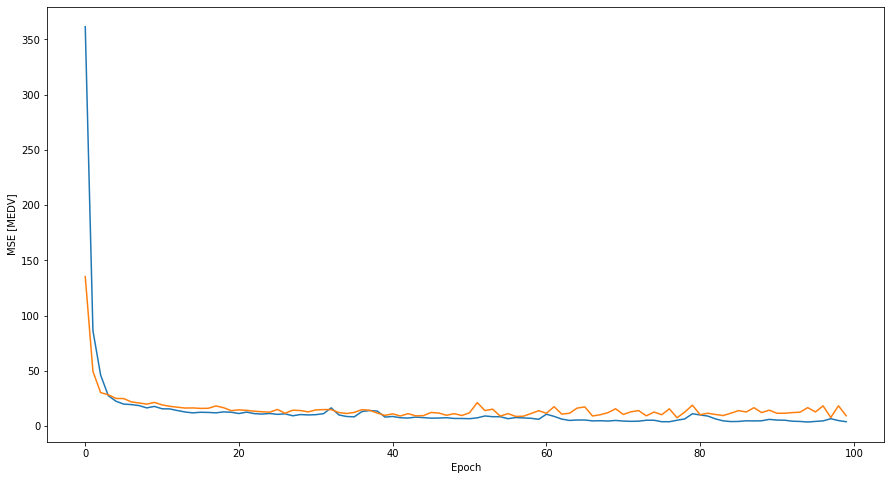

In [77]:
plt.figure(figsize=(15,8))

plt.xlabel('Epoch')
plt.ylabel('MSE [MEDV]')

plt.plot(model.history.history['loss'][:])
plt.plot(model.history.history['val_loss'][:])

### Make predictions

Finally, predict MEDV values using data in the testing set:

In [78]:
from sklearn.metrics import mean_absolute_error

# Let's check how much we are off on average
y_pred = model.predict(normed_test_data)
mae = mean_absolute_error(test_labels, y_pred)

print(f"We are off on average by {round(mae * 1000, 2)} US dollars, while the mean price of a house in the dataset is {round(boston['MEDV'].mean() * 1000, 2)}.")

We are off on average by 2103.75 US dollars, while the mean price of a house in the dataset is 22532.81.


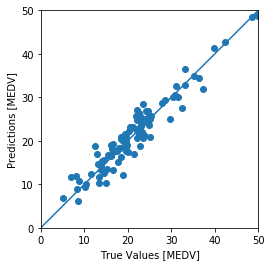

In [79]:
test_predictions = model.predict(normed_test_data).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MEDV]')
plt.ylabel('Predictions [MEDV]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

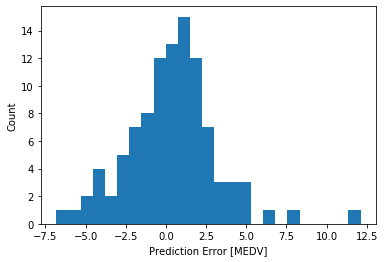

In [80]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MEDV]")
_ = plt.ylabel("Count")